# Important Notes

- to prevent overfitting to outliers using MAE loss, we used log transformation of the measured and inferred BNPP values when calculating BNPP loss
- Weights acquired from the first stage of training(BNPP) were frozen, except for the fully connected layers at the end of the model: one for BNPP and one for BNP. Both BNP and BNPP datasets were used to train the stage 2 model to jointly predict BNP and BNPP from a chest radiograph.
- ensures that for each epoch for stage 2, the entire BNP training set was used (n =1124), while an equal number of BNPP labeled images were randomly sampled without replacement from the BNPP training dataset
- ROC curves were computed after binary thresholding of BNP and BNPP measurements, according to previously established screening thresholds for acute heart failure detection (greater than 400 for BNPP, greater than 100 for BNP)

## Imports and Read Ins
'''{toggle}'''

In [2]:
import torch
import math
import torch.nn as nn
import pandas as pd
import os, time, sys
import numpy as np
import seaborn as sns
import pytorch_lightning as pl
import h5py
sys.path.append(os.path.dirname(os.path.realpath('.')))
from torchvision.models import resnet152, ResNet152_Weights
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as Func
from torchvision import transforms as T
from PIL import Image
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score, roc_curve, confusion_matrix
import glob
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
pio.renderers.default = 'svg'
pio.templates.default = 'plotly_white'
import cv2
from helpers.lightning_interface import *

In [3]:
from helpers.lightning_interface import *

In [3]:
torch.cuda.is_available()

True

## DataSet

In [4]:
DATA_PATH = '/home/jmryan/teams/dsc-180a---a14-[88137]/df_bnpp_datapaths.csv'
KEY_PATH = '/home/jmryan/teams/dsc-180a---a14-[88137]/df_bnpp_keys.csv'

In [4]:
df_datapaths = pd.read_csv(DATA_PATH, header=None).T.merge(pd.read_csv(KEY_PATH, header=None).T, left_index=True, right_index=True)

In [5]:
## Read in, combine and clean
df_datapaths = pd.read_csv(DATA_PATH, header=None).T.merge(pd.read_csv(KEY_PATH, header=None).T, left_index=True, right_index=True)
df_datapaths.columns = ['filepaths', 'key']
df_datapaths.key = df_datapaths.key.apply(lambda x: eval(x))
df_datapaths.filepaths = df_datapaths.filepaths.apply(lambda x: eval(x))
df_datapaths = df_datapaths.set_index('key')

## Clean train, val, test
cols= ['unique_key', 'bnpp_value_log', 'BNPP_weight', 'PNA_mask', 'PNA_wight_mask', 'BNP_value', 'age_at_sampletime']
test_df = pd.read_csv('bnpp_test.csv', usecols = cols).set_index('unique_key')
train_df = pd.read_csv('bnpp_train.csv', usecols = cols).set_index('unique_key')
val_df = pd.read_csv('bnpp_val.csv', usecols = cols).set_index('unique_key')
train_df['heart'] = train_df['BNP_value'].apply(lambda x: int(x > 400))
test_df['heart'] = test_df['BNP_value'].apply(lambda x: int(x > 400))
val_df['heart'] = val_df['BNP_value'].apply(lambda x: int(x > 400))
all_df = pd.concat([train_df, val_df, test_df])

## Combo w df_datapaths
train_df = train_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)
test_df = test_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)
val_df = val_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)

## Class
class PreprocessedImageDataset(Dataset):
    def __init__(self, df, transform=None, target_transform=None):
        self.df = df
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df[idx]
        filepath = row[7]  
        val = row[0]
        heart = row[6]
        im = torch.load(filepath)
        return im.view(1, 224, 224).expand(3, -1, -1), val, heart

In [6]:
class ResNet152_Transform(object):
    def __init__(self, composed):
        self.composed = composed
    
    def __call__(self, sample):
#         data_tr = torch.moveaxis(sample, 1, 0)
        #print(sample)
        print(sample.shape)
        im = self.composed(sample).detach()
        #print(im)
        return im

In [7]:
resnet152_trnsf = ResNet152_Transform(transforms.Compose([
    #T.ToPILImage(),
    T.Resize([224, 224], interpolation=T.InterpolationMode.BILINEAR),
    T.ToTensor(),
    #T.Normalize(0.49459884, 0.0918)
]))

In [8]:
hf_path = '/home/jmryan/teams/dsc-180a---a14-[88137]/bnpp_frontalonly_1024_'
hf_paths = []
hfs = []
for i in range(11):
    #print(os.path.exists(hf_path+str(i)+'.hdf5'))
    if i >= 7 and i != 10:
        continue
    hf_paths.append(hf_path+str(i)+'.hdf5')
    hfs.append(h5py.File(hf_path+str(i)+'.hdf5', 'r'))
    print(i)

0
1
2
3
4
5
6
10


In [9]:
cols= ['unique_key', 'bnpp_value_log', 'BNPP_weight', 'PNA_mask', 'PNA_wight_mask', 'BNP_value', 'age_at_sampletime']
test_df = pd.read_csv('bnpp_test.csv', usecols = cols).set_index('unique_key')
train_df = pd.read_csv('bnpp_train.csv', usecols = cols).set_index('unique_key')
val_df = pd.read_csv('bnpp_val.csv', usecols = cols).set_index('unique_key')
train_df['heart'] = train_df['BNP_value'].apply(lambda x: int(x > 400))
test_df['heart'] = test_df['BNP_value'].apply(lambda x: int(x > 400))
val_df['heart'] = val_df['BNP_value'].apply(lambda x: int(x > 400))
all_df = pd.concat([train_df, val_df, test_df])

In [10]:
train_df

,bnpp_value_log,BNPP_weight,PNA_mask,PNA_wight_mask,BNP_value,age_at_sampletime,heart
unique_key,,,,,,,
Flodure_51396672_img1,0.690196,1,None,1,4.9,45,0
Okepik_50995691_img1,0.690196,1,None,1,4.9,53,0
Kuesluco_51713925_img1,0.690196,1,None,1,4.9,54,0
Gumepra_51602745_img1,0.690196,1,None,1,4.9,58,0
Gapeklik_51060218_img1,0.690196,1,None,1,4.9,19,0
...,...,...,...,...,...,...,...
Puesrueci_53095611_img1,4.845099,1,None,1,70000.1,57,1
Adakas_52269723_img1,4.845099,1,None,1,70000.1,73,1
Ekugud_52967627_img1,4.845099,1,None,1,70000.1,53,1


In [11]:
train_df = train_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)
test_df = test_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)
val_df = val_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)

In [12]:
hfs_keys = []
for hf in hfs:
    hfs_keys.append(list(hf.keys()))

In [13]:
train_locs = {}
val_locs = {}
test_locs = {}
for i in range(len(hfs_keys)):
    for key in hfs_keys[i]:
        if key in train_df.index:
            train_locs[key] = i
        elif key in val_df.index:
            val_locs[key] = i
        elif key in test_df.index:
            test_locs[key] = i

In [14]:
train_locs_df = pd.DataFrame(train_locs, index=[1]).T
train_locs_df.columns = ['hf_loc']
val_locs_df = pd.DataFrame(val_locs, index=[1]).T
val_locs_df.columns = ['hf_loc']
test_locs_df = pd.DataFrame(test_locs, index=[1]).T
test_locs_df.columns = ['hf_loc']

In [15]:
train_df = train_df.merge(train_locs_df, how='inner', left_index=True, right_index=True)
val_df = val_df.merge(val_locs_df, how='inner', left_index=True, right_index=True)
test_df = test_df.merge(test_locs_df, how='inner', left_index=True, right_index=True)

In [45]:
train_df.filepaths = train_df.filepaths.apply(lambda x: '/'.join(x.split('/')[-2:]))
val_df.filepaths = val_df.filepaths.apply(lambda x: '/'.join(x.split('/')[-2:]))
test_df.filepaths = test_df.filepaths.apply(lambda x: '/'.join(x.split('/')[-2:]))
train_df = train_df[['bnpp_value_log', 'heart', 'filepaths']]
val_df = val_df[['bnpp_value_log', 'heart', 'filepaths']]
test_df = test_df[['bnpp_value_log', 'heart', 'filepaths']]
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [ ]:
train_df.to_csv(TRAIN_PATH)
test_df.to_csv(TEST_PATH)
val_df.to_csv(VAL_PATH)

# HERE LOAD

In [5]:
TEST_PATH = '/home/jmryan/private/DSC180/A/test/testdata.csv'
TRAIN_PATH = '/home/jmryan/private/DSC180/A/train/traindata.csv'
VAL_PATH = '/home/jmryan/private/DSC180/A/val/valdata.csv'

In [6]:
train_df = pd.read_csv(TRAIN_PATH, index_col=0)
val_df = pd.read_csv(VAL_PATH, index_col=0)
test_df = pd.read_csv(TEST_PATH, index_col=0)

In [7]:
DATA_DIR_PATH = '/home/jmryan/teams/dsc-180a---a14-[88137]/bnpp_224_pandas/'

In [8]:
class PreprocessedImageDataset(Dataset):
    def __init__(self, df, transform=None, target_transform=None):
        self.df = df
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df[idx]
        filepath = row[2]  
        val = row[0]
        heart = row[1]
        im = torch.load(DATA_DIR_PATH + filepath)
        return im.view(1, 224, 224).expand(3, -1, -1), val, heart

In [9]:
class ImageDataset(Dataset):
    def __init__(self, hfs, df, transform=None, target_transform=None, use_one = True):
        self.use_one = use_one
        if use_one:
            self.hfs = hfs[0]
        else:
            self.hfs = np.array(hfs)
        self.df = df
        self.transform = transform
        self.pil = T.ToPILImage()
        self.tens = T.ToTensor()
        self.resize = T.Resize([224, 224], interpolation=T.InterpolationMode.BILINEAR)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        key = self.df.index[idx]
        if self.use_one:
            im = np.array(self.hfs[key][:,:])
        else:
            which_hf = int(self.df.iloc[idx].hf_loc)
            im = self.hfs[which_hf][key][:,:]
        val = self.df.loc[key].bnpp_value_log
        heart = self.df.loc[key].heart
        im = (im-im.min())/(im.max() - im.min())
        im = self.tens(self.resize(self.pil(im.copy())))[0]
        return im.view(1, 224, 224).expand(3, -1, -1), val, heart

In [10]:
train_dataset = PreprocessedImageDataset(df=train_df.to_numpy())
val_dataset = PreprocessedImageDataset(df=val_df.to_numpy())
test_dataset = PreprocessedImageDataset(df=test_df.to_numpy())

In [11]:
COLLATE_SIZE = (224, 224)

In [12]:
def collate_fn_xray(data):
    x, y, heart = list(zip(*data))
    
    # handle malformed data:
    msk = [x_i.shape == COLLATE_SIZE for x_i in x]
    x = [x_i for x_i in x if x_i.shape == COLLATE_SIZE]
    y = [y_i for i, y_i in enumerate(y) if msk[i]]
    heart = [heart_i for i, heart_i in enumerate(heart) if msk[i]]
    
    # if everythin is malformed
    if len(x) == 0:
        return torch.tensor([]), torch.tensor([]), np.array([])
        
    return torch.stack(x), y, heart

In [13]:
BATCH_SIZE = 32
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=16, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers = 16, shuffle=False)

## BNPP Metrics

In [13]:
all_df

,bnpp_value_log,BNPP_weight,PNA_mask,PNA_wight_mask,BNP_value,age_at_sampletime,BNP_value.1,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
unique_key,,,,,,,,,,,,,,,,,
Flodure_51396672_img1,0.690196,1.0,None,1.0,4.9,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Okepik_50995691_img1,0.690196,1.0,None,1.0,4.9,53.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kuesluco_51713925_img1,0.690196,1.0,None,1.0,4.9,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gumepra_51602745_img1,0.690196,1.0,None,1.0,4.9,58.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gapeklik_51060218_img1,0.690196,1.0,None,1.0,4.9,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Eslinik_51387018_img1,4.845099,1.0,None,1.0,70000.1,59.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Padaswou_51641346_img1,4.845099,1.0,None,1.0,70000.1,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Crifape_51290561_img1,4.845099,1.0,None,1.0,70000.1,59.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [149]:
ids = pd.concat([pd.Series(test_df.index), pd.Series(train_df.index), pd.Series(val_df.index)]).iloc[:-1].to_numpy()
in_ = []
hf_keys = list(hf.keys())
for im in ids:
    if im in hf_keys:
        in_.append(im)
actual_all = all_df.loc[in_]

In [150]:
def age_helper(x):
    if x > 90:
        return '> 90'
    elif x > 80:
        return '> 80'
    elif x > 70:
        return '> 70'
    elif x > 60:
        return '> 60'
    elif x > 50:
        return '> 50'
    elif x > 40:
        return '> 40'
    elif x > 30: 
        return '> 30'
    elif x >= 20:
        return '> 20'

In [151]:
actual_all['age_group'] = actual_all['age_at_sampletime'].apply(age_helper)

### Whole Set Stats

In [162]:
stats_bnpp = [actual_all.BNP_value.mean(), actual_all.BNP_value.std(), actual_all.BNP_value.min(), actual_all.BNP_value.max(),
 actual_all.BNP_value.median(), len(actual_all.BNP_value)]
pd.DataFrame(stats_bnpp, index = ['Mean', 'STD', 'Min', 'Max', 'Median', 'Count'], columns=['BNPP'])

,BNPP
Mean,4958.361048
STD,10944.872530
Min,4.900000
Max,70000.100000
Median,937.500000
Count,706.000000


In [168]:
stats_heart = [actual_all.heart.mean(), actual_all.heart.sum(), len(actual_all.heart)]
pd.DataFrame(stats_heart, index = ['Mean', 'Sum', 'Count'], columns=['Is Heart'])

,Is Heart
Mean,0.637394
Sum,450.000000
Count,706.000000


### Age group breakdown for BNPP Raw

In [159]:
actual_all[['age_group', 'BNP_value']].groupby('age_group').agg(
    ['mean', 'std', 'min', 'max', 'median', 'count']).sort_index()

BNP_value                                           
                  mean           std   min      max  median count
age_group                                                        
> 20       5391.504167  14767.180635   6.0  70000.1   252.0    24
> 30       3816.414286   8689.215551   4.9  37905.0   471.0    35
> 40       4397.902597   9858.064132   4.9  54607.0   403.0    77
> 50       3885.609589   9997.732103   4.9  70000.1   623.0   146
> 60       6100.635922  12662.312680   4.9  70000.1  1212.5   206
> 70       5176.419048  11203.797668  22.0  70000.1  1371.0   126
> 80       4440.040541   7282.442271  32.0  34989.0  1548.5    74
> 90       5231.777778  10903.987806  99.0  41461.0   894.0    18

### Age group breakdown for BNPP Class

In [158]:
actual_all[['age_group', 'heart']].groupby('age_group').agg(
    ['mean', 'sum', 'count'])

heart           
               mean  sum count
age_group                     
> 20       0.458333   11    24
> 30       0.571429   20    35
> 40       0.506494   39    77
> 50       0.554795   81   146
> 60       0.674757  139   206
> 70       0.706349   89   126
> 80       0.756757   56    74
> 90       0.833333   15    18

## Model

138.99999999999997


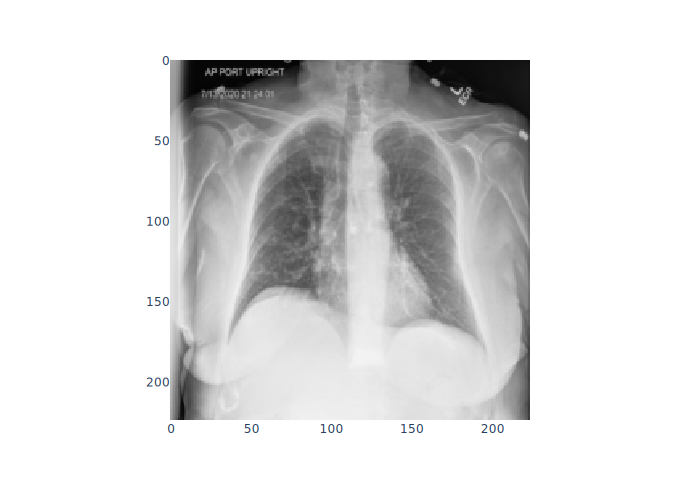

In [149]:
for x,y, _ in train_dl:
    print(10 ** y[0].item())
    px.imshow(x[0].permute(1, 2, 0).numpy()).show()
    break

### SuperNet

In [14]:
model = resnet152(weights=ResNet152_Weights.DEFAULT)

In [15]:
class SuperNet(SuperFace):
    def __init__(self, layer_defs, linear_layers, lr = 1e-3, is_transfer=False, model=None, lr_scheduler = [], print_on = True):
        super().__init__(layer_defs = layer_defs, lr_scheduler = lr_scheduler, lr=lr)
        
        self.model = model
        self.print = print_on
        self.linear_layers = linear_layers
        self.grad = False
        self.val_heart_true_epoch = np.array([])
        self.val_heart_hat_epoch = np.array([])
        self.train_heart_true_epoch = np.array([])
        self.train_heart_hat_epoch = np.array([])
        self.val_mae_epoch = np.array([])
        self.train_mae_epoch = np.array([])
        self.train_loss_epoch = np.array([])
        self.val_loss_epoch = np.array([])
        self.val_auc = np.array([])
        self.init_model()
            
    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=self.lr) 
        lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, verbose=True)
        return {"optimizer": optim}#, "lr_scheduler": {'scheduler': lr_sched, 'monitor': 'loss', 
                                    #                 'interval': 'epoch'}}
    
    def init_model(self):
        layers = list(model.children())
        lin = layers[-1]
        layers = layers[:-1]
        temp_lin = [nn.Linear(num_in,num_out) for num_in, num_out in self.linear_layers]
        total_lin = []
        for lin in temp_lin:
            total_lin.append(nn.Dropout(0.75))
            total_lin.append(lin)
        self.regresser = nn.Sequential(*total_lin)
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.grad:
            represents = self.layers(x).flatten(1)
            y_hat = self.regresser(represents)
        else:
            represents = x
            for i in range(len(self.layers)):
                if self.current_epoch >= 5 and (i == 8 or i==7 or i ==6 or i==5 or i==4):
                    represents = self.layers[i](represents)
                    
#                 elif self.current_epoch >= 10 and i == 7:
#                     represents = self.layers[i](represents)
                    
#                 elif self.current_epoch >= 15 and i == 6:
#                     represents = self.layers[i](represents)
                    
#                 elif self.current_epoch >= 20 and i == 5:
#                     represents = self.layers[i](represents)

                else:
                    with torch.no_grad():
                        represents = self.layers[i](represents)
            y_hat = self.regresser(represents.flatten(1))
        del x
        return y_hat
    
    
    def turn_grad(self, boo):
        self.grad = boo
    
    def training_step(self, batch, batch_idx):
        x, y, heart = batch
        
        y_hat = self(x)
        #print(y_hat.detach().mean().item(), y.mean().item(), y_hat.detach().median().item(), y.median().item())
        del x
        
#         loss = self.loss_func(y_hat, y)
        
        loss = self.mae(y_hat, y)
        
        m_a_e = self.mae(y_hat, y).detach()
        
        y_heart = ((10**y_hat) > 400).long()
        
        loss_dic = {'loss': loss,
                    'y_hat': y_hat,
                    'y_true': y,
                    'heart_true': heart,
                    'heart_hat': y_heart,
                    'mae': m_a_e
                   }
        
        return loss_dic
    
    def validation_step(self, batch, batch_idx):
        x, y, heart = batch
        
        y_hat = self(x)
        del x
#         loss = self.loss_func(y_hat, y)
        
        m_a_e = self.mae(y_hat, y).detach()
        
        loss = self.mae(y_hat, y).detach()

        y_heart = ((10**y_hat) > 400).long()
        
        loss_dic = {'loss': loss,
                    'y_hat': y_hat,
                    'y_true': y,
                    'heart_true': heart,
                    'heart_hat': y_heart,
                    'mae': m_a_e
                   }
        
        return loss_dic
    
        
    def training_step_end(self, batch_loss):
        total_loss = batch_loss['loss'].mean()
        heart_true = batch_loss['heart_true'].to('cpu').numpy()
        heart_hat = batch_loss['heart_hat'].to('cpu').numpy()
        step_mae = batch_loss['mae'].to('cpu').numpy()
        
        self.train_heart_true_epoch = np.append(self.train_heart_true_epoch, heart_true)
        self.train_heart_hat_epoch = np.append(self.train_heart_hat_epoch, heart_hat)
        self.train_mae_epoch = np.append(self.train_mae_epoch, step_mae)
        
        torch.cuda.empty_cache()
        out = 'training_step (pre del) mem %:', torch.cuda.memory_allocated() / torch.cuda.max_memory_allocated()
        #print(out)        
        return total_loss
    
    def validation_step_end(self, batch_loss):
        total_loss = batch_loss['loss'].mean()
        heart_true = batch_loss['heart_true'].to('cpu').numpy()
        heart_hat = batch_loss['heart_hat'].to('cpu').numpy()
        step_mae = batch_loss['mae'].to('cpu').numpy()
        
        self.val_heart_true_epoch = np.append(self.val_heart_true_epoch, heart_true)
        self.val_heart_hat_epoch = np.append(self.val_heart_hat_epoch, heart_hat)
        self.val_mae_epoch = np.append(self.val_mae_epoch, step_mae)
        
        return total_loss
        
    def training_epoch_end(self, step_outputs):
        
        losses = [loss['loss'] for loss in step_outputs]
        
        heart_true = self.train_heart_true_epoch
        heart_hat = self.train_heart_hat_epoch
        epoch_mae = self.train_mae_epoch
        total_loss = sum(losses)/len(losses)
        auc = roc_auc_score(heart_true, heart_hat)
        prc = precision_score(heart_true, heart_hat, zero_division=0)
        
# #         self.log('train_AUC', auc,
#                 on_step=False, on_epoch=True, prog_bar=True, batch_size=BATCH_SIZE)
        
#         self.log('train_PRC', prc,
#                 on_step=False, on_epoch=True, prog_bar=True, batch_size=BATCH_SIZE)
        
        self.log('loss', total_loss,
                on_step=False, on_epoch=True, prog_bar=False, batch_size=BATCH_SIZE)
        
        
        info_dic = {'AUC': auc, 'PRC': prc, 'loss':total_loss.item()}
        print(f"Epoch {self.current_epoch}")
        if self.print:
            print(f"Epoch {self.current_epoch}")
            print(f"\tTrain {info_dic}; mean_mae: {epoch_mae.mean()};" + 
                 f" mean_heart_hat: {heart_hat.mean()}; mean_heart_true: {heart_true.mean()}")
#        print(f"\tTrain loss: {total_loss.item()}; mean_mae: {epoch_mae.mean()};" + 
 #            f" mean_heart_hat: {heart_hat.mean()}; mean_heart_true: {heart_true.mean()}")
        
        self.train_loss_epoch = np.append(self.train_loss_epoch, total_loss.item())
        
        self.train_heart_true_epoch = np.array([])
        self.train_heart_hat_epoch = np.array([])
        self.train_mae_epoch = np.array([])
        #sch = self.lr_schedulers()
        #print(self.lr_schedulers())

        # If the selected scheduler is a ReduceLROnPlateau scheduler.

        return None
        
    def validation_epoch_end(self, step_outputs):
        losses = step_outputs

        heart_true = self.val_heart_true_epoch
        heart_hat = self.val_heart_hat_epoch
        epoch_mae = self.val_mae_epoch
        total_loss = sum(losses)/len(losses)

        auc = roc_auc_score(heart_true, heart_hat)
        prc = precision_score(heart_true, heart_hat, zero_division=0)

#         self.log('val_AUC', auc,
#                 on_step=False, on_epoch=True, prog_bar=True, batch_size=BATCH_SIZE)
        
#         self.log('val_PRC', prc,
#                 on_step=False, on_epoch=True, prog_bar=True, batch_size=BATCH_SIZE)
        
# #         self.log('val_loss', total_loss,
#                 on_step=False, on_epoch=True, prog_bar=True, batch_size=BATCH_SIZE)
        
        
        info_dic = {'AUC': auc, 'PRC': prc,'loss': total_loss.item()}
        
        if self.print:
            print(f"\tVal {info_dic}; mean_mae: {epoch_mae.mean()};" + 
                 f" mean_heart_hat: {heart_hat.mean()}; mean_heart_true: {heart_true.mean()}")
#         print(f"\tVal loss: {total_loss.item()}; mean_mae: {epoch_mae.mean()};" + 
#              f" mean_heart_hat: {heart_hat.mean()}; mean_heart_true: {heart_true.mean()}")
        
        self.val_auc = np.append(self.val_auc, auc)
        self.val_heart_true_epoch = np.array([])
        self.val_heart_hat_epoch = np.array([])
        self.val_mae_epoch = np.array([])
        self.val_loss_epoch = np.append(self.val_loss_epoch, total_loss.item())

        
        return None
        
    def loss_func(self, y_hat, y_true):
        y_true = y_true.view(-1, 1)
        return torch.abs(torch.log(1 + y_true) - torch.log(1 + y_hat))
    
    def mae(self, y_hat, y_true):
        y_true = y_true.view(-1,1)
        return torch.abs(y_true - y_hat)

### Train

In [16]:
torch.cuda.is_available()

True

In [17]:
os.cpu_count()

64

In [14]:
lin_choices = [[[2048,1]],
               [[2048, 1024], [1024, 512], [512,256], [256,1]],
               [[2048, 256], [256,1]],
               [[2048, 4096], [4096, 2048], [2048, 512], [512, 256], [256, 1]]]
all_aucs = []
all_tests = []
all_val_loss = []
all_train_loss = []
for lin_lay in lin_choices:
    print(lin_lay)
    net = SuperNet(layer_defs=None, linear_layers = lin_lay, is_transfer=True, 
               model = model, lr_scheduler=True, lr = 1e-5, print_on = False)
    trainer = pl.Trainer(
        accelerator='gpu',
        max_epochs=30, 
        enable_progress_bar=False,
        logger=False,
        enable_checkpointing=False)
    net.train()
    trainer.fit(net, train_dl, val_dl)
    print(net.val_auc)
    net.eval()
    test_outcomes = []
    for each in test_dataset:
        test_outcomes.append(net(each[0].reshape((1,3,224,224))).item())
    all_aucs.append(net.val_auc)
    all_tests.append(test_outcomes)
    all_val_loss.append(net.val_loss_epoch)
    all_train_loss.append(net.train_loss_epoch)
    

[[2048, 1]]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | model     | ResNet     | 60.2 M
1 | regresser | Sequential | 2.0 K 
2 | layers    | Sequential | 58.1 M
-----------------------------------------
60.2 M    Trainable params
0         Non-trainable params
60.2 M    Total params
240.779   Total estimated model params size (MB)


Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28


`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29
[0.5        0.5        0.50751945 0.53352781 0.54552247 0.53230001
 0.53856322 0.53650877 0.53682747 0.54167595 0.54691397 0.62785963
 0.64228608 0.6514391  0.6650447  0.6714391  0.705876   0.69333507
 0.6962812  0.71056194 0.7072199  0.70934924 0.71479566 0.71659584
 0.71155579 0.72004412 0.70830953 0.71584988 0.71637699 0.70876582
 0.71684372]
[[2048, 1024], [1024, 512], [512, 256], [256, 1]]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | model     | ResNet     | 60.2 M
1 | regresser | Sequential | 2.8 M 
2 | layers    | Sequential | 58.1 M
-----------------------------------------
62.9 M    Trainable params
0         Non-trainable params
62.9 M    Total params
251.789   Total estimated model params size (MB)


Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28


`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29
[0.5        0.71591664 0.72292987 0.71659584 0.73213921 0.72764078
 0.72963892 0.7262156  0.72595727 0.73055149 0.72492802 0.72214443
 0.72959306 0.7346186  0.73714385 0.7373064  0.72776791 0.73604377
 0.73166202 0.72768664 0.73324974 0.71929815 0.72386741 0.7337455
 0.7285429  0.73063276 0.73693545 0.72653431 0.73312261 0.73367468
 0.74027749]
[[2048, 256], [256, 1]]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | model     | ResNet     | 60.2 M
1 | regresser | Sequential | 524 K 
2 | layers    | Sequential | 58.1 M
-----------------------------------------
60.7 M    Trainable params
0         Non-trainable params
60.7 M    Total params
242.870   Total estimated model params size (MB)


Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28


`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29
[0.5        0.7248868  0.74270695 0.7433612  0.73959828 0.73491234
 0.73760014 0.73249332 0.73797515 0.73422269 0.74134216 0.74518635
 0.73721468 0.73554569 0.7312098  0.73872518 0.73395391 0.74244224
 0.72882619 0.73009927 0.7376251  0.74133171 0.72135667 0.73676245
 0.73469349 0.74182341 0.74208174 0.73967317 0.73608325 0.74424242
 0.73837513]
[[2048, 4096], [4096, 2048], [2048, 512], [512, 256], [256, 1]]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | model     | ResNet     | 60.2 M
1 | regresser | Sequential | 18.0 M
2 | layers    | Sequential | 58.1 M
-----------------------------------------
78.2 M    Trainable params
0         Non-trainable params
78.2 M    Total params
312.627   Total estimated model params size (MB)


Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28


`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29
[0.5        0.74698653 0.73914606 0.75373099 0.74433415 0.74932428
 0.74209219 0.74340067 0.74965343 0.74106293 0.74489667 0.7559625
 0.73521015 0.7539185  0.75199118 0.75383722 0.74877627 0.74182341
 0.75878149 0.75147858 0.75526239 0.7371125  0.76415709 0.75270579
 0.75978579 0.75791478 0.75087658 0.74369035 0.74459248 0.74489667
 0.74138802]


In [70]:
final_lin = [[2048, 4096], [4096, 2048], [2048, 512], [512, 256], [256, 1]]
all_aucs = []
all_tests = []
all_val_loss = []
all_train_loss = []

net = SuperNet(layer_defs=None, linear_layers = final_lin, is_transfer=True, 
           model = model, lr_scheduler=True, lr = 1e-5, print_on = False)
trainer = pl.Trainer(
    accelerator='gpu',
    max_epochs=30, 
    enable_progress_bar=False,
    logger=False,
    enable_checkpointing=False)
net.train()
trainer.fit(net, train_dl, val_dl)
print(net.val_auc)
net.eval()
test_outcomes = []
for each in test_dataset:
    test_outcomes.append(net(each[0].reshape((1,3,224,224))).item())
all_aucs.append(net.val_auc)
all_tests.append(test_outcomes)
all_val_loss.append(net.val_loss_epoch)
all_train_loss.append(net.train_loss_epoch)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | model     | ResNet     | 60.2 M
1 | regresser | Sequential | 18.0 M
2 | layers    | Sequential | 58.1 M
-----------------------------------------
78.2 M    Trainable params
0         Non-trainable params
78.2 M    Total params
312.627   Total estimated model params size (MB)


Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28


`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29
[0.5        0.53588819 0.54887263 0.54871822 0.56380529 0.57104551
 0.66039011 0.68719494 0.69072855 0.71091199 0.71660223 0.71439974
 0.72212353 0.7206525  0.71036398 0.72293626 0.73798154 0.73010565
 0.72905143 0.72509462 0.72720945 0.73480611 0.73169743 0.72591141
 0.7453843  0.72966388 0.74677406 0.73367468 0.73132648 0.73692093
 0.74143388]


In [178]:
net.val_loss_epoch

array([2.8518192 , 0.85149043, 0.8023674 , 0.76903959, 0.76187612,
       0.74419419, 0.65895255, 0.63065952, 0.60047391, 0.59227967,
       0.5814034 , 0.56591039, 0.56273857, 0.57009391, 0.57255353,
       0.57399456, 0.56121774, 0.56456768, 0.56711689, 0.56134391,
       0.55002085, 0.54977429, 0.54977673, 0.54792187, 0.54660484,
       0.54666277, 0.54908931, 0.54199143, 0.54475788, 0.54073097,
       0.53763217])

In [85]:
net.load_state_dict(torch.load('final_model'))

<All keys matched successfully>

In [72]:
np.save('final_aucs.csv',np.array(all_aucs))
np.save('final_tests.csv', np.array(all_tests))
np.save('final_val_loss.csv', np.array(all_val_loss))
np.save('final_train_loss.csv', np.array(all_train_loss))

In [10]:
tests = np.load('final_tests.csv.npy')

In [12]:
tests_bin = (10**tests[0]) > 400

In [13]:
y_true_bin = (10**np.array(y_true)) > 400

In [108]:
df = pd.DataFrame()

In [109]:
df['tests_bin'] = tests_bin
df['tests'] = (10**tests[0])
df['y_true'] = (10**np.array(y_true))
df['y_true_bin'] = y_true_bin

In [127]:
def helper(x):
    if x[0] == True and x[3] == True:
        return 'TP'
    elif x[0] == True and x[3] == False:
        return 'FP'
    elif x[0] == False and x[3] == False:
        return 'TN'
    else:
        return 'FN'

In [128]:
df['type'] = df.apply(helper, axis=1)

In [138]:
FN = 186
FP = 1364
TN = 696
TP = 1156
exs = [TP, FP, FN, TN]
order = ['TP', 'FP', 'FN', 'TN']

In [137]:
df[df.type == 'TP'].sort_values('y_true', ascending=False).head(10)

,tests_bin,tests,y_true,y_true_bin,type
295,True,3648.280745,70000.1,True,TP
736,True,3132.367693,70000.1,True,TP
1272,True,1287.311099,70000.1,True,TP
1062,True,1814.686877,70000.1,True,TP
1025,True,5226.933043,70000.1,True,TP
1156,True,12600.646223,70000.1,True,TP
1545,True,10423.371869,70000.1,True,TP
85,True,702.491869,70000.1,True,TP
909,True,544.074545,70000.1,True,TP
330,True,2920.342817,70000.1,True,TP


<AxesSubplot:>

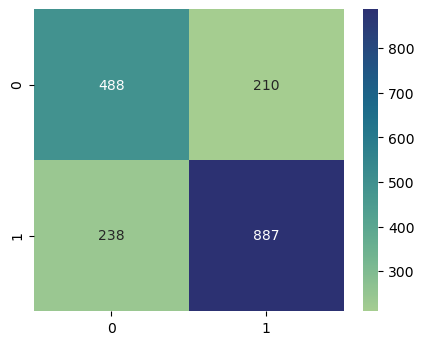

In [20]:
plt.figure(figsize=(5,4), dpi=100)
sns.heatmap(confusion_matrix(y_true_bin, tests_bin), annot=True, fmt=".0f", cmap='crest')


In [21]:
np.array(all_tests).shape

(4, 1823)

In [23]:
np.save('aucs.csv',np.array(all_aucs))
np.save('tests.csv', np.array(all_tests))
np.save('val_loss.csv', np.array(all_val_loss))
np.save('train_loss.csv', np.array(all_train_loss))

In [195]:
tests = np.load('final_tests.csv.npy')

In [11]:
y_true = [x[1] for x in test_dataset]

In [18]:
from sklearn.metrics import roc_curve

In [54]:
def plot_roc_curve(true_y, y_prob, which_one, final_auc):
    """
    plots the roc curve based of the probabilities
    """
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr, label=which_one + ': ' + str(final_auc.round(4)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [200]:
net.val_auc

array([0.5       , 0.53588819, 0.54887263, 0.54871822, 0.56380529,
       0.57104551, 0.66039011, 0.68719494, 0.69072855, 0.71091199,
       0.71660223, 0.71439974, 0.72212353, 0.7206525 , 0.71036398,
       0.72293626, 0.73798154, 0.73010565, 0.72905143, 0.72509462,
       0.72720945, 0.73480611, 0.73169743, 0.72591141, 0.7453843 ,
       0.72966388, 0.74677406, 0.73367468, 0.73132648, 0.73692093,
       0.74143388])

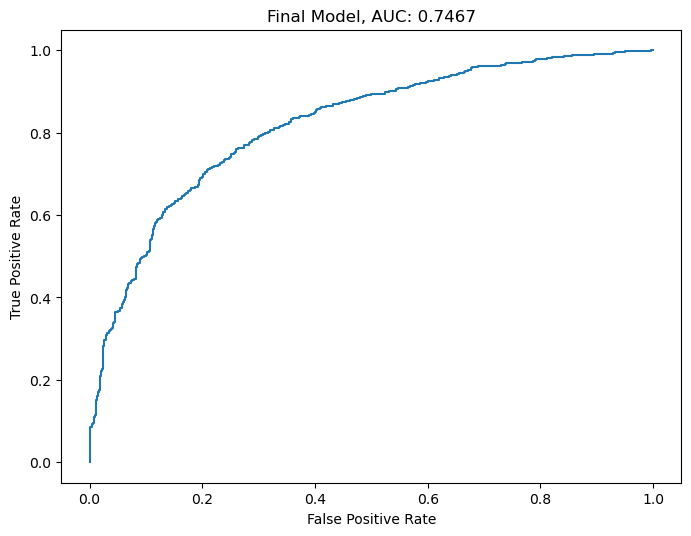

In [205]:
plt.figure(figsize=(8,6), dpi=100)
fpr, tpr, thresholds = roc_curve((10**np.array(y_true)) > 400, tests[0])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final Model, AUC: 0.7467')
plt.savefig('presentation_figs/final_auc.png')

In [207]:
df.iloc[exs]

,tests_bin,tests,y_true,y_true_bin,type
1156,True,12600.646223,70000.1,True,TP
1364,True,3925.629093,14.0,False,FP
186,False,329.788634,55009.0,True,FN
696,False,48.287919,4.9,False,TN


In [48]:
aucs = np.load('aucs.csv.npy')
final_aucs = [x[-1] for x in aucs]

<Figure size 432x288 with 0 Axes>

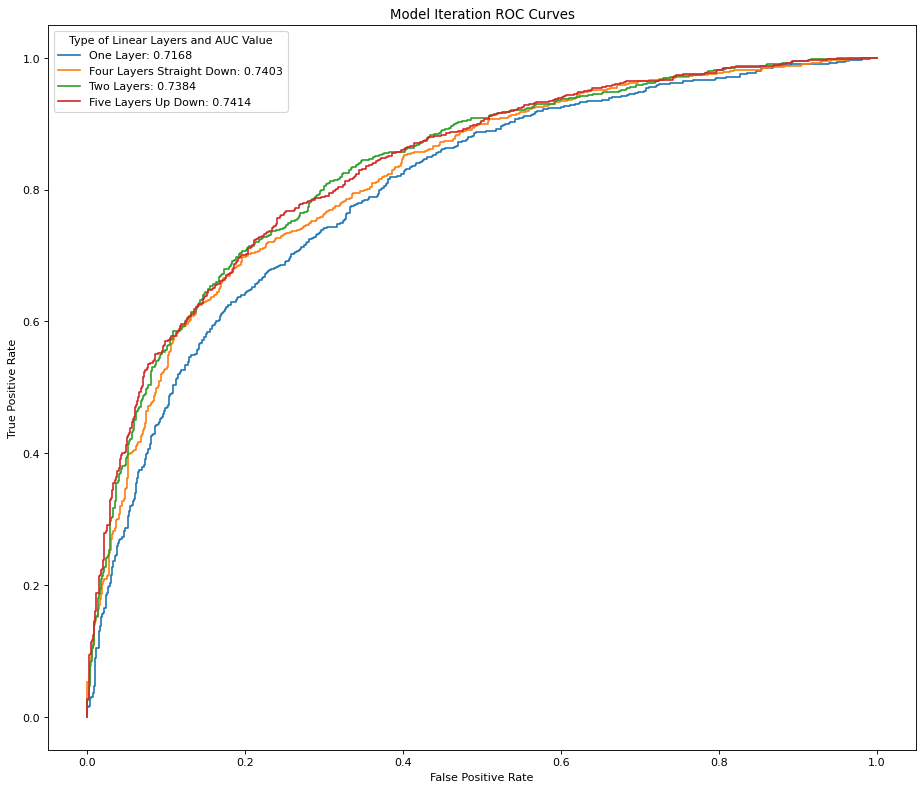

In [67]:
fig = plt.gcf()
plt.figure(figsize=(14, 12), dpi=80)
which = ['One Layer', 'Four Layers Straight Down', 'Two Layers', 'Five Layers Up Down']
for i in range(len(tests)):
    plot_roc_curve(((10**np.array(y_true)) > 400), (10**tests[i]), which[i], final_aucs[i])
plt.legend(title='Type of Linear Layers and AUC Value')
plt.title('Model Iteration ROC Curves')
fig = plt.gcf()
fig.savefig('presentation_figs/auroc.png', dpi=100)

In [ ]:
high, low, mid, tp, tn, fp, fn

In [ ]:
figure(figsize=(8, 6), dpi=80)

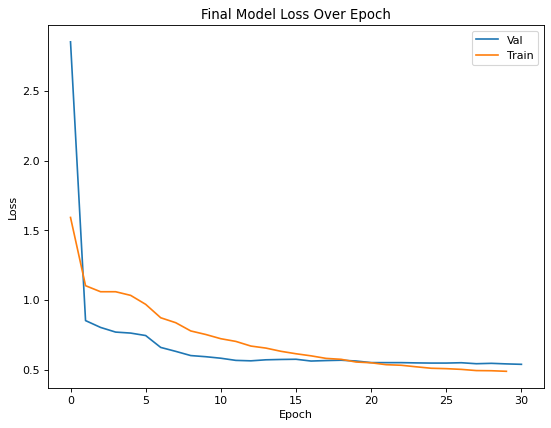

In [204]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(np.arange(len(net.val_loss_epoch) ),  net.val_loss_epoch)
plt.plot(np.arange(len(net.train_loss_epoch)),  net.train_loss_epoch)
plt.legend(['Val','Train'])
plt.title('Final Model Loss Over Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('presentation_figs/final_loss.png')
plt.show()

In [18]:
[x.max() for x in all_aucs]

[0.6825194473470335, 0.703961453616626, 0.7062719145477766, 0.7092284918146987]

In [83]:
trainer = pl.Trainer(
    accelerator='gpu',
    max_epochs=100, 
    enable_progress_bar=False,
    logger=False,
    enable_checkpointing=False
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [84]:
net.train()
trainer.fit(net, train_dl, val_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | model     | ResNet     | 60.2 M
1 | regresser | Sequential | 18.0 M
2 | layers    | Sequential | 58.1 M
-----------------------------------------
78.2 M    Trainable params
0         Non-trainable params
78.2 M    Total params
312.627   Total estimated model params size (MB)


	Val {'AUC': 0.5, 'PRC': 0.0, 'loss': 2.8325858937498074}; mean_mae: 2.8325858937498074; mean_heart_hat: 0.0; mean_heart_true: 0.546875
	Val {'AUC': 0.6443678160919539, 'PRC': 0.7429643527204502, 'loss': 0.6964721450082786}; mean_mae: 0.6968928632334721; mean_heart_hat: 0.5572399372713016; mean_heart_true: 0.6210141139571353
Epoch 0
	Train {'AUC': 0.5767966236764717, 'PRC': 0.6879313951056264, 'loss': 0.8469999922655193}; mean_mae: 0.8469810469412445; mean_heart_hat: 0.6305724083355315; mean_heart_true: 0.6312318649432868
	Val {'AUC': 0.6168123766399629, 'PRC': 0.6887886597938144, 'loss': 0.6826183462064073}; mean_mae: 0.6829869119876179; mean_heart_hat: 0.8112911657083115; mean_heart_true: 0.6210141139571353
Epoch 1
	Train {'AUC': 0.6361749995665709, 'PRC': 0.7221486665405712, 'loss': 0.6705080592165202}; mean_mae: 0.670530990947955; mean_heart_hat: 0.6973094170403588; mean_heart_true: 0.6312318649432868
	Val {'AUC': 0.6645553233484268, 'PRC': 0.7624045801526718, 'loss': 0.67826861278

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1b85ec7af0>
Traceback (most recent call last):
  File "/home/jmryan/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1b85ec7af0>self._shutdown_workers()

Traceback (most recent call last):
  File "/home/jmryan/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/home/jmryan/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        if w.is_alive():Exception ignored in: self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f1b85ec7af0>Exception ignored in:   File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
  File "/home/jmryan/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

Exception i

    self._shutdown_workers()
  File "/home/jmryan/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1b85ec7af0>
Traceback (most recent call last):
  File "/home/jmryan/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/jmryan/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception 

    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1b85ec7af0>
Traceback (most recent call last):
  File "/home/jmryan/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/jmryan/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1b85ec7af0>
Traceback (most recent call last):
  File "/home/jmryan/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()


	Val {'AUC': 0.7034279577383026, 'PRC': 0.7812773403324584, 'loss': 0.6179880201737497}; mean_mae: 0.6183254236036306; mean_heart_hat: 0.5974908520648197; mean_heart_true: 0.6210141139571353
Epoch 12
	Train {'AUC': 0.7297528422491206, 'PRC': 0.7846401210630852, 'loss': 0.5299926811256607}; mean_mae: 0.5299314082509993; mean_heart_hat: 0.6972434713795832; mean_heart_true: 0.6312318649432868
	Val {'AUC': 0.6999692325554394, 'PRC': 0.7740016992353441, 'loss': 0.6201229071795892}; mean_mae: 0.6203802407254739; mean_heart_hat: 0.6152639832723471; mean_heart_true: 0.6210141139571353
Epoch 13
	Train {'AUC': 0.7466062869946739, 'PRC': 0.7967858501331304, 'loss': 0.4999278528767964}; mean_mae: 0.49991083407916453; mean_heart_hat: 0.6934845687153786; mean_heart_true: 0.6312318649432868
	Val {'AUC': 0.6799169859514687, 'PRC': 0.7409326424870466, 'loss': 0.6265749686871747}; mean_mae: 0.6266113639488888; mean_heart_hat: 0.7062205959226346; mean_heart_true: 0.6210141139571353
Epoch 14
	Train {'AUC'

/home/jmryan/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning:

Detected KeyboardInterrupt, attempting graceful shutdown...



## SALIENCY

In [19]:
final_lin = [[2048, 4096], [4096, 2048], [2048, 512], [512, 256], [256, 1]]
net = SuperNet(layer_defs=None, linear_layers = final_lin, is_transfer=True, 
           model = model, lr_scheduler=True, lr = 1e-5, print_on = False)

In [21]:
net.load_state_dict(torch.load('presentation_figs/final_model'))

<All keys matched successfully>

In [29]:
from helpers.gradcam import NetworkGradCAM
import matplotlib as mpl
from skimage.transform import resize
import saliency.core as saliency

In [30]:
saliency.INPUT_OUTPUT_GRADIENTS?

In [ ]:
def call_model_function(val, call_model_args, expected_keys):
    pred = gCAM(val.view((1,3,224,224)).to('cuda'))
    pred.backward(retain_graph=True)
    gradients = gCAM.get_activations_gradient()
    return {saliency.INPUT_OUTPUT_GRADIENTS: grads}

In [25]:
net.turn_grad(True)

In [26]:
gCAM = NetworkGradCAM(net)

# set evaluation mode
gCAM.eval()

NetworkGradCAM(
  (encoder_pre_list): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [27]:
val = test_dataset[exs[0]][0]

NameError: name 'exs' is not defined

In [28]:
net.to('cuda')

SuperNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [148]:
val.max()

tensor(0.9311)

In [174]:
ims = []
base_ims = []
for num in exs:
    val = test_dataset[num][0]
    pred = gCAM(val.view((1,3,224,224)).to('cuda'))
    pred.backward(retain_graph=True)
    gradients = gCAM.get_activations_gradient()
    activations = gCAM.get_activations(val.view((1,3,224,224)).to('cuda')).detach()
    gCAM.zero_grads()
    pooled_gradients = torch.mean(gradients, dim = [0, 2, 3])

    for i in range(pooled_gradients.shape[0]):
        activations[:, i, ...] *= pooled_gradients[i]

    heatmap = torch.mean(activations[0], dim = 0).squeeze()
    heatmap = np.maximum(heatmap.cpu(), 0)
    heatmap /= torch.max(heatmap)
    heatmap2 = cv2.resize(heatmap.numpy(), (224,224))
    heatmap2 = np.uint8(255 * heatmap2)
    t2 = val.permute(1, 2, 0).numpy()
    t3 = np.uint8(255*t2)
    heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)
    base_ims.append(t3)
    superimposed_img = (heatmap2 * 0.4) + t3
    superimposed_img = np.uint8(255*(superimposed_img-superimposed_img.min())/(superimposed_img.max() - superimposed_img.min()))
    ims.append(superimposed_img)

In [168]:
order[3]

'TN'

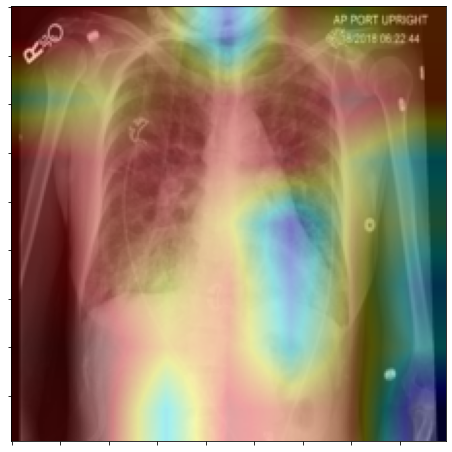

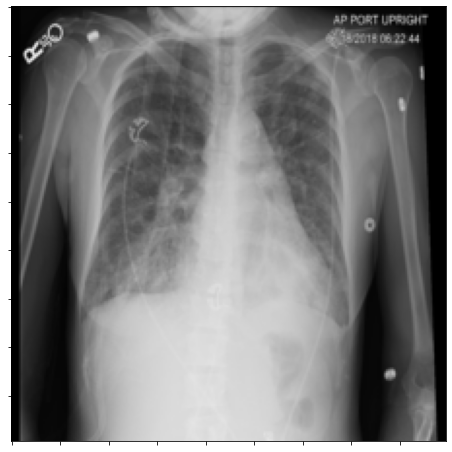

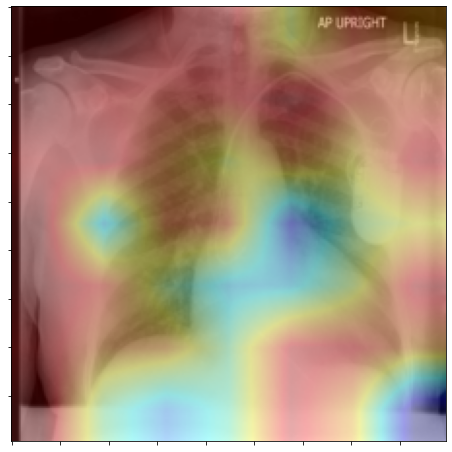

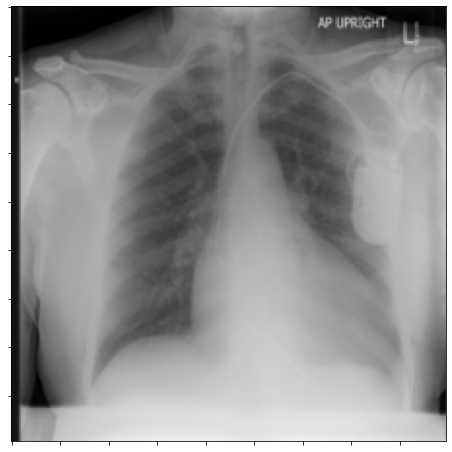

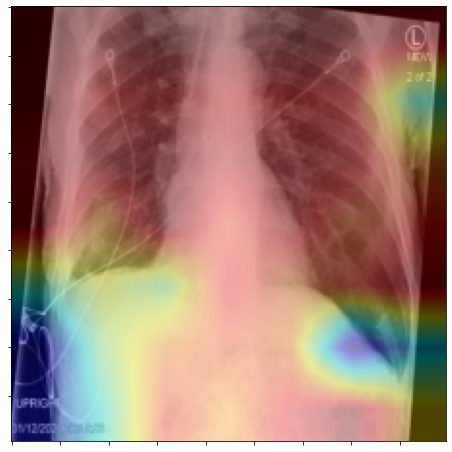

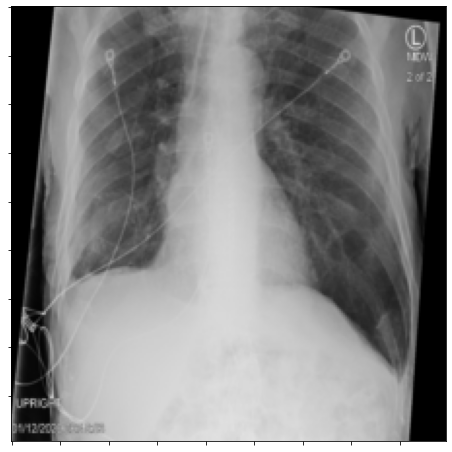

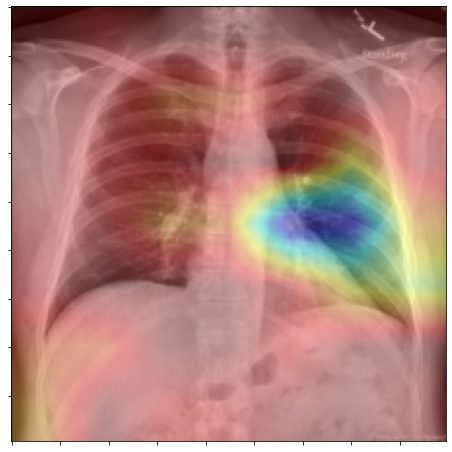

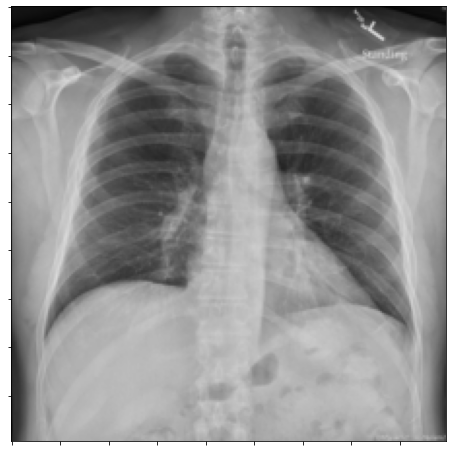

In [177]:
for i in range(len(ims)):
    fig, axs = plt.subplots(1, 1, figsize = (8,8))
    axs.imshow(ims[i].astype(int))
    axs.set_yticklabels([])
    axs.set_xticklabels([])
    fig.savefig(order[i] + '_gcam.png', dpi=100)
    
    fig, axs = plt.subplots(1, 1, figsize = (8,8))
    axs.imshow(base_ims[i].astype(int))
    axs.set_yticklabels([])
    axs.set_xticklabels([])
    fig.savefig(order[i] + '_base.png', dpi=100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


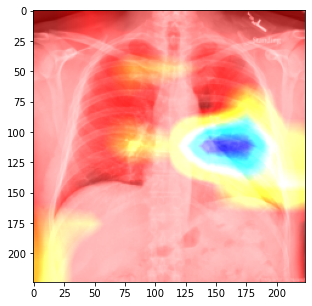

In [161]:
fig, axs = plt.subplots(1, 1, figsize = (5,5))
axs.imshow(heatmap2.astype(int) + t3)
plt.show()

In [151]:
val = val.view((1,3,224,224))

In [152]:
pred = gCAM(val.to('cuda'))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [97]:
pred

tensor([[2.6963]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [199]:
pred.backward(retain_graph=True)

In [200]:
gradients = gCAM.get_activations_gradient()
activations = gCAM.get_activations(val.to('cuda')).detach()
gCAM.zero_grads()

In [201]:
gradients.shape

torch.Size([1, 2048, 7, 7])

In [202]:
activations.shape

torch.Size([1, 2048, 7, 7])

In [203]:
pooled_gradients = torch.mean(gradients, dim = [0, 2, 3])

In [204]:
pooled_gradients.shape

torch.Size([2048])

In [205]:
for i in range(pooled_gradients.shape[0]):
    activations[:, i, ...] *= pooled_gradients[i]

In [206]:
heatmap = torch.mean(activations[0], dim = 0).squeeze()
    # Apply a RELU
heatmap = np.maximum(heatmap.cpu(), 0)
    # normalize heatmap
heatmap /= torch.max(heatmap)

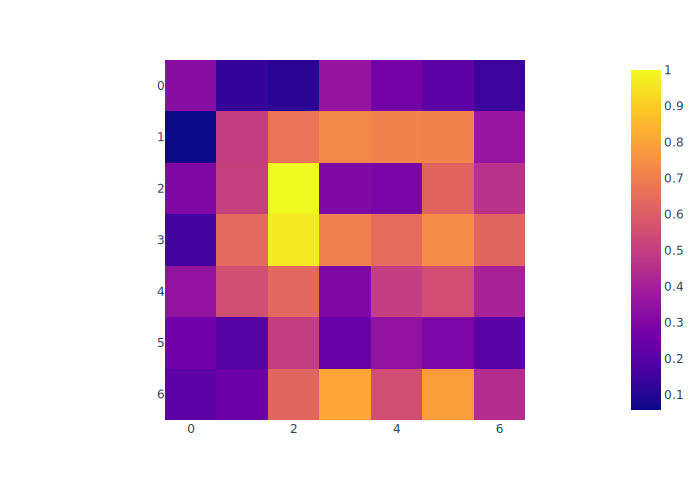

In [163]:
px.imshow(heatmap).show()

In [117]:
from skimage.transform import resize

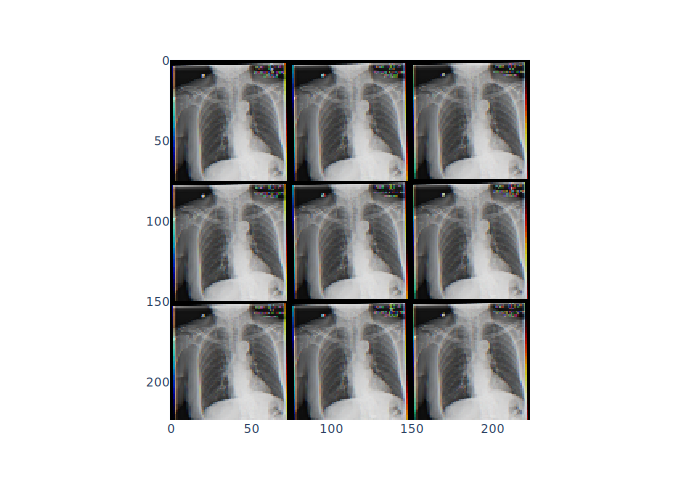

In [118]:
px.imshow(val[0].reshape((224,224,3)))

In [186]:
heatmap = resize(heatmap.numpy(), (224, 224), preserve_range=True)

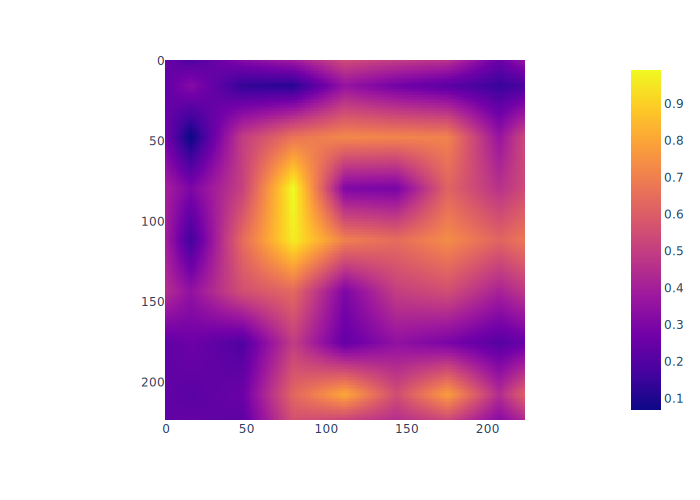

In [125]:
px.imshow(heatmap).show()

In [189]:
cmap = mpl.cm.get_cmap('jet', 256)
heatmapcm = cmap(heatmap, alpha = 0.4)

In [ ]:
tt

In [140]:
val.shape

torch.Size([1, 3, 224, 224])

In [260]:
t2 = val[0].permute(1, 2, 0).numpy()

In [264]:
t2.mean()

0.44585875

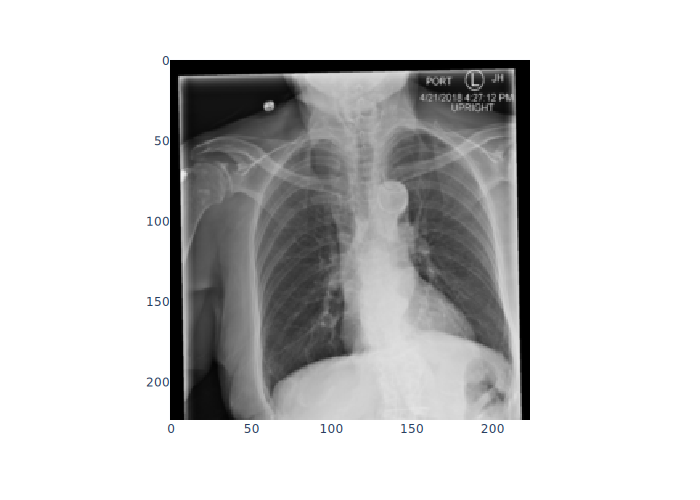

In [259]:
px.imshow(val[0].permute(1, 2, 0).numpy()).show()

In [176]:
np.array([[[0.7] * 224] * 224]).shape

(224, 224)

In [183]:
ttbw = np.concatenate((tt, np.moveaxis(np.array([[[1.0] * 224] * 224]), 0, 2)), axis=2)

In [257]:
tt = resize(val[0].permute(1,2,0).numpy(), (224, 224), preserve_range=True).astype(int)

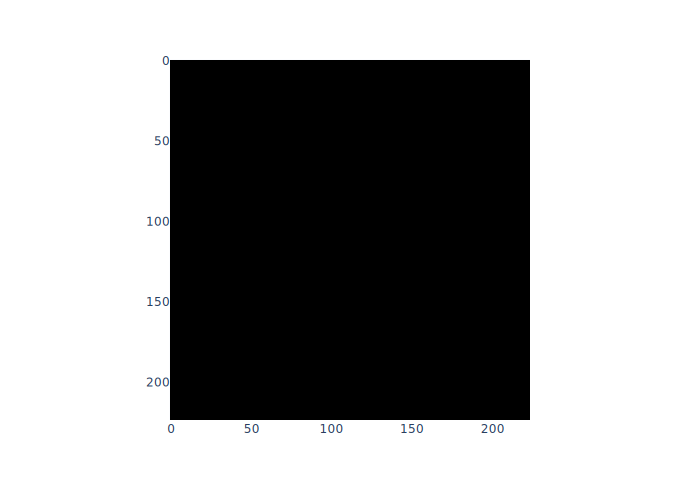

In [258]:
px.imshow(tt)

In [170]:
bw = mpl.cm.get_cmap('binary', 256)
ttbw = bw(tt, alpha=0.7)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


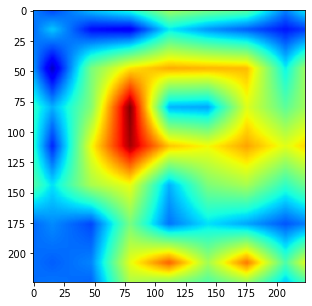

In [190]:
fig, axs = plt.subplots(1, 1, figsize = (5,5))
axs.imshow(ttbw+heatmapcm)
plt.show()

In [237]:
heatmap.shape

torch.Size([7, 7])

In [208]:
tt.shape

(224, 224, 3)

In [212]:
cv2.resize(heatmap.numpy(), (224,224))

array([[0.32307458, 0.32307458, 0.32307458, ..., 0.14503539, 0.14503539,
        0.14503539],
       [0.32307458, 0.32307458, 0.32307458, ..., 0.14503539, 0.14503539,
        0.14503539],
       [0.32307458, 0.32307458, 0.32307458, ..., 0.14503539, 0.14503539,
        0.14503539],
       ...,
       [0.21859184, 0.21859184, 0.21859184, ..., 0.44244698, 0.44244698,
        0.44244698],
       [0.21859184, 0.21859184, 0.21859184, ..., 0.44244698, 0.44244698,
        0.44244698],
       [0.21859184, 0.21859184, 0.21859184, ..., 0.44244698, 0.44244698,
        0.44244698]], dtype=float32)

In [295]:
import cv2
heatmap2 = cv2.resize(heatmap.numpy(), (tt.shape[1], tt.shape[0]))
heatmap2 = np.uint8(255 * heatmap2)
t3 = np.uint8(255*t2)
heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)
superimposed_img = (heatmap2 * 0.4) + t3

In [291]:
superimposed_img.max()

255

In [296]:
superimposed_img = np.uint8(25*(superimposed_img-superimposed_img.min())/(superimposed_img.max() - superimposed_img.min()))

In [297]:
superimposed_img = np.uint8(255*superimposed_img)

type(superimposed_img.astype(int))

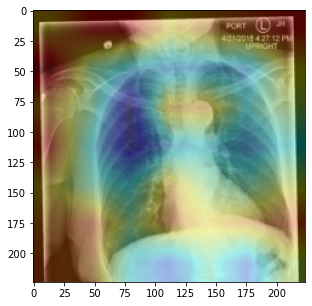

In [298]:
fig, axs = plt.subplots(1, 1, figsize = (5,5))
axs.imshow(superimposed_img.astype(int))
plt.show()

In [217]:
tt.shape

(224, 224, 3)

In [216]:
heatmap2.shape

(224, 224, 3)

In [219]:
!pip uninstall opencv-python-headless

In [222]:
cv2.imshow('t',superimposed_img)

error: OpenCV(4.6.0) /io/opencv/modules/highgui/src/window.cpp:1267: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


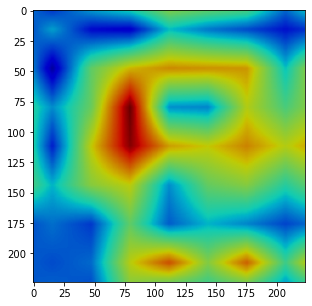

In [167]:
fig, axs = plt.subplots(1, 1, figsize = (5,5))
axs.imshow(tt)
axs.imshow(heatmap)
plt.show()

In [49]:
pred = gCAM(val.to('cuda'))
del val
# get index of prediction made
print(pred)
pred_ind = pred.argmax(dim=1)
# back propagate the prediction
pred[0][pred_ind].backward(retain_graph=True)

# get the gradients and the activations
gradients = gCAM.get_activations_gradient()
activations = gCAM.get_activations(val[0][0].unsqueeze(0)).detach()
gCAM.zero_grads()

print(gradients.shape), print(activations.shape)
# pool the gradients (average them across each convolution layer)
pooled_gradients = torch.mean(gradients, dim = [0, 2, 3])

print(pooled_gradients.shape)
# multiply the average gradient of each layer by that layer's activations
for i in range(pooled_gradients.shape[0]):
    activations[:, i, ...] *= pooled_gradients[i]
    
# for each feature (currently there are 4 encoders per feature
heatmap_feat_list = []
for i in range(gCAM.N_FEATS):
    len_enc = int(activations.shape[1] / gCAM.N_FEATS)
     # average each features gradCAMS
    heatmap = torch.mean(activations[0][i*len_enc:(i+1)*len_enc], dim = 0).squeeze()
    # Apply a RELU
    heatmap = np.maximum(heatmap, 0)
    # normalize heatmap
    heatmap /= torch.max(heatmap)
    
    heatmap_feat_list.append(heatmap)

RuntimeError: CUDA out of memory. Tried to allocate 98.00 MiB (GPU 0; 10.76 GiB total capacity; 9.43 GiB already allocated; 3.44 MiB free; 9.78 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
for i, h in enumerate(heatmap_feat_list):
    px.imshow(h).show()

In [ ]:
heatmap_feat_list_rs = []
for h in heatmap_feat_list:
    heatmap_feat_list_rs.append(resize(h.numpy(), (224, 224), preserve_range=True))

In [ ]:
for i, h in enumerate(heatmap_feat_list_rs):
    px.imshow(h).show()

Best Val AUC: 65%, using three linear layers

In [113]:
net.configure_optimizers()

{'optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     eps: 1e-08
     foreach: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ),
 'lr_scheduler': {'scheduler': <torch.optim.lr_scheduler.ReduceLROnPlateau at 0x7efb60567fd0>,
  'monitor': 'loss',
  'interval': 'epoch'}}

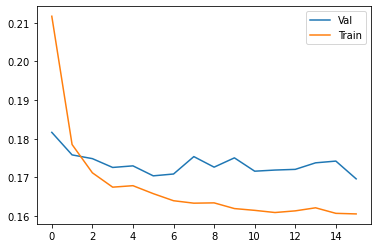

In [121]:
plt.plot(np.arange(len(net.val_loss_epoch) - 1),  net.val_loss_epoch[1:])
plt.plot(np.arange(len(net.train_loss_epoch)),  net.train_loss_epoch)
plt.legend(['Val','Train'])
plt.show()

In [61]:
ex.view(-1,1)

tensor([[1],
        [2],
        [3],
        [4]])

In [190]:
10**.68

4.786300923226384

In [ ]:
## Two optimizers, one loss one auc